In [ ]:
import pandas as pd
import requests
from io import BytesIO
import numpy as np
from PIL import Image, ImageOps
from keras.models import load_model  # TensorFlow is required for Keras to work

In [ ]:
df = pd.read_csv('/content/finalWithEnvironmentData.csv')

In [ ]:
x_shape = (len(df), 224, 224, 3)
x_data = np.empty(x_shape)

In [ ]:
# Function to check if a row is empty
def is_empty_row(row):
    return np.all(row == 0)

In [ ]:
for i in range(len(df)):
  row = df.iloc[i]
  url = row['mosquitohabitatmapperWaterSourcePhotoUrls']
  if ';' in url:
    url = url.split(';')[0]
  response = requests.get(url)
  image_bytes = BytesIO(response.content)
  image = Image.open(image_bytes)
  size = (224, 224)
  image = ImageOps.fit(image, size, Image.Resampling.LANCZOS)
  image_array = np.asarray(image)
  normalized_image_array = (image_array.astype(np.float32) / 127.5) - 1

    # Load the image into the array
  x_data[i] = normalized_image_array

print(df.loc[i, 'mosquitohabitatmapperWaterSourcePhotoUrls'])


# Check which rows are empty
empty_row_indices = [i for i, row in enumerate(x_data) if is_empty_row(row)]

# Delete the empty rows
x_data = np.delete(x_data, empty_row_indices, axis=0)



11500
11501
11502
11503
11504
11505
11506
11507
11508
11509
11510
11511
11512
11513
11514
11515
11516
11517
11518
11519
11520
11521
11522
11523
11524
11525
11526
11527
11528
11529
11530
11531
11532
11533
11534
11535
11536
11537
11538
11539
11540
11541
11542
11543
11544
11545
11546
11547
11548
11549
11550
11551
11552
11553
11554
11555
11556
11557
11558
11559
11560
11561
11562
11563
11564
11565
11566
11567
11568
11569
11570
11571
11572
11573
11574
11575
11576
11577
11578
11579
11580
11581
11582
11583
11584
11585
11586
11587
11588
11589
11590
11591
11592
11593
11594
11595
11596
11597
11598
11599
11600
11601
11602
11603
11604
11605
11606
11607
11608
11609
11610
11611
11612
11613
11614
11615
11616
11617
11618
11619
11620
11621
11622
11623
11624
11625
11626
11627
11628
11629
11630
11631
11632
11633
11634
11635
11636
11637
11638
11639
11640
11641
11642
11643
11644
11645
11646
11647
11648
11649
11650
11651
11652
11653
11654
11655
11656
11657
11658
11659
11660
11661
11662
11663
11664
11665
1166

In [ ]:
model = load_model('/content/keras_model.h5', compile = False)

# Load the labels
class_names = open("/content/labels.txt", "r").readlines()



In [ ]:
predictions = model.predict(x_data)

for i in range(len(predictions)):
  prediction = predictions[i]
  index = np.argmax(prediction)
  class_name = class_names[index]
  df.at[i, 'environment_classification'] = class_name


31/31 [==============================] - 16s 523ms/step


In [ ]:
df.to_csv('DataWithEnvironmentLabeled.csv')

In [ ]:
frequency_table = pd.crosstab(df['environment_classification'], df['AI Identified Genus'])

print(frequency_table)

observed_data = np.array(frequency_table)

AI Identified Genus         aedes  anopheles  culex
environment_classification                         
0 Rural\n                     923        213    753
1 Suburban\n                 3610       1024   3540
2 Urban\n                    1192        239    987
[[ 923  213  753]
 [3610 1024 3540]
 [1192  239  987]]


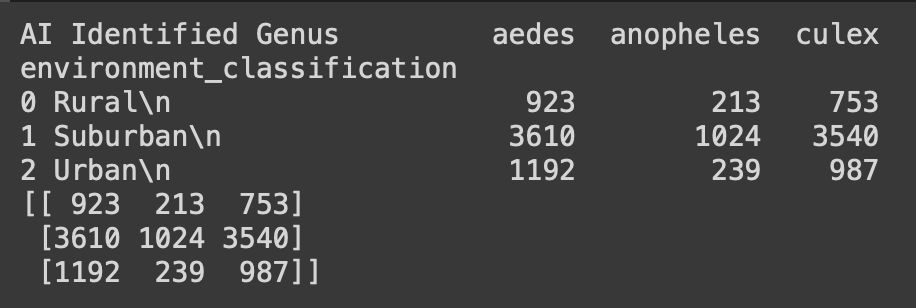

In [ ]:
from scipy.stats import chi2_contingency
import scipy.stats as stats

frequency_table = pd.crosstab(df['environment_classification'], df['AI Identified Genus'])
chi2, p, dof, expected = stats.chi2_contingency(frequency_table)

print(frequency_table)
observed_data = np.array(frequency_table)
print("Chi-Squared:", chi2)
print("P-value:", p)
print("Degrees of Freedom:", dof)
print("Expected Frequencies Table:\n")
print(frequency_table)
print(pd.DataFrame(expected, index=frequency_table.index, columns=frequency_table.columns))

contribution_data = (((observed_data - expected) ** 2)/ expected)

# Output the contributions
print("Contribution to Chi-Squared Statistic:")

for i in range(len(contribution_data)):
  for z in range(len(contribution_data[i])):
    if observed_data[i][z] - expected[i][z] < 0:
      contribution_data[i][z] *= -1

rows = ['Rural', 'Suburban', 'Urban']
columns = ['aedes', 'anopheles', 'culex']

df_custom = pd.DataFrame(contribution_data, index = rows, columns = columns)
print(df_custom)


AI Identified Genus         aedes  anopheles  culex
environment_classification                         
0 Rural\n                     923        213    753
1 Suburban\n                 3610       1024   3540
2 Urban\n                    1192        239    987
Chi-Squared: 32.52603518733284
P-value: 1.4934060731727213e-06
Degrees of Freedom: 4
Expected Frequencies Table:

AI Identified Genus         aedes  anopheles  culex
environment_classification                         
0 Rural\n                     923        213    753
1 Suburban\n                 3610       1024   3540
2 Urban\n                    1192        239    987
AI Identified Genus               aedes   anopheles        culex
environment_classification                                      
0 Rural\n                    866.479048  223.392677   799.128275
1 Suburban\n                3749.391074  966.655236  3457.953690
2 Urban\n                   1109.129877  285.952087  1022.918035
Contribution to Chi-Squared Statistic:
  

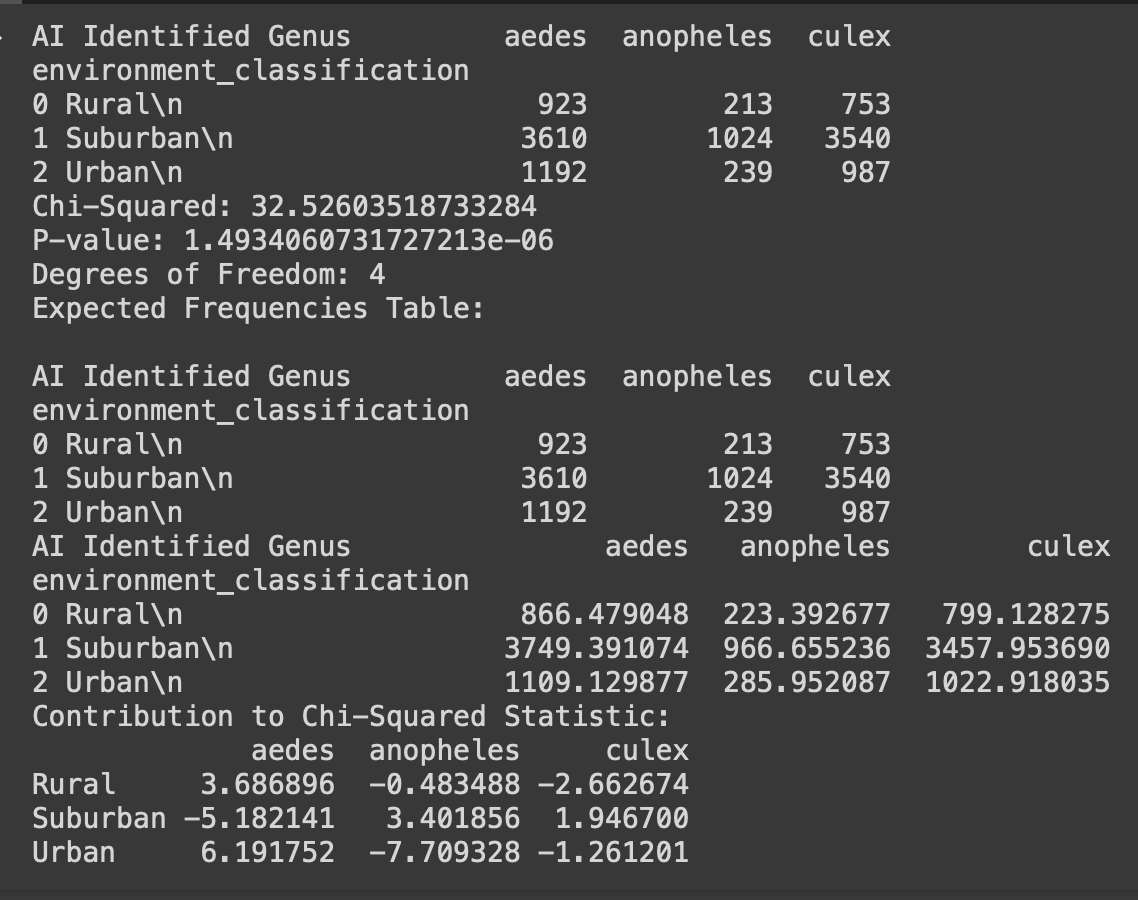

In [ ]:

# Formatting frequency_table
frequency_table_styled = frequency_table.style.background_gradient(cmap='coolwarm')
print("Frequency Table:")
print(frequency_table_styled)

# Formatting df_custom (contribution_data)
df_custom_styled = df_custom.style.background_gradient(cmap='coolwarm', axis=None)
print("Contribution to Chi-Squared Statistic:")
print(df_custom_styled)

# If you want to display the tables using matplotlib, you can use the .render() method
# to generate HTML and display it using IPython.display.HTML
from IPython.display import HTML

html_frequency_table = frequency_table_styled.render()
html_df_custom = df_custom_styled.render()

HTML("<h2>Frequency Table:</h2>" + html_frequency_table + "<h2>Contribution to Chi-Squared Statistic:</h2>" + html_df_custom)

Frequency Table:
Contribution to Chi-Squared Statistic:


<ipython-input-8-8bfdc5ed404b>:17: FutureWarning: this method is deprecated in favour of `Styler.to_html()`
  html_frequency_table = frequency_table_styled.render()
<ipython-input-8-8bfdc5ed404b>:18: FutureWarning: this method is deprecated in favour of `Styler.to_html()`
  html_df_custom = df_custom_styled.render()


AI Identified Genus,aedes,anopheles,culex
environment_classification,,,
0 Rural,923,213,753
1 Suburban,3610,1024,3540
2 Urban,1192,239,987
,aedes,anopheles,culex
Rural,3.686896,-0.483488,-2.662674
Suburban,-5.182141,3.401856,1.946700
Urban,6.191752,-7.709328,-1.261201


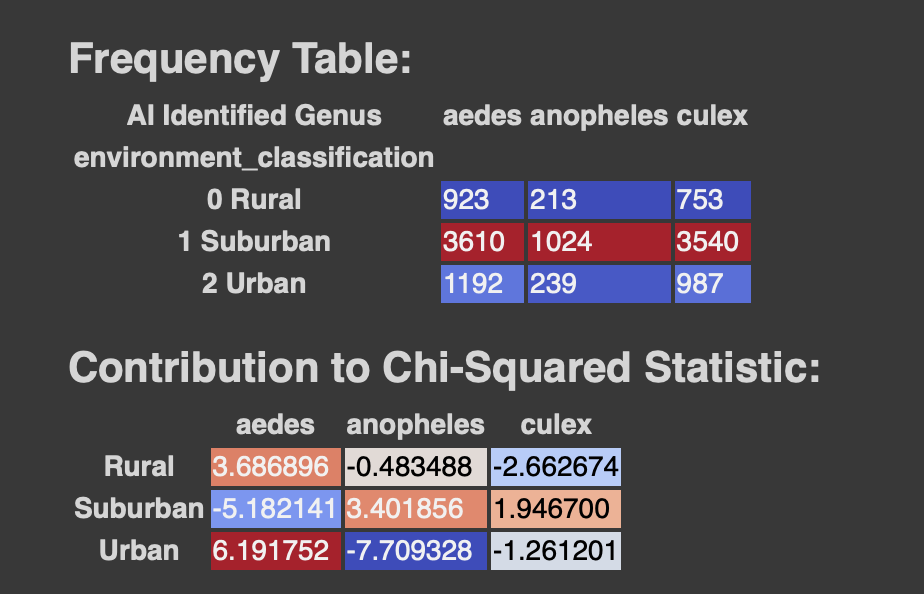